The aim of this notebook is to develop a unique player performance index, splitting by player's position n the court and considering a different set of variables dependeding on this position. 

All stats have been aggregated by player (regardless of the team, season and country where he played) to come up with the methodology to create the index. When implemented, the performance index will be able to calculate by season or team.

## Imports

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

from sklearn import decomposition
from sklearn import cluster
import umap
from sklearn.metrics import silhouette_score, silhouette_samples, precision_recall_fscore_support
import pingouin as pg
from factor_analyzer import FactorAnalyzer

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.2f}'.format)

#path='C:/Repo/MiM_Analytics_Tesis/Tesis/'
path='C:/Users/E0662122/Repo/MiM_Analytics_Tesis/Tesis/'

In [2]:
postgreSQL = {"host": "localhost", "port": "5432", "username": "postgres", 
               "password": "trivisono", "database": "SportsAnalytics"}

uri = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
postgreSQL['username'], postgreSQL['password'], postgreSQL['host'], postgreSQL['port'], postgreSQL['database'])

engine = create_engine(uri)
conn = engine.raw_connection()
cursor = conn.cursor()

In [3]:
df = pd.read_sql_query("SELECT * FROM fdm.dash_ft_abt_all_seasons;", conn)

rating_correction = pd.read_sql_query("SELECT player_id, \
    SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) wavg_player_rating \
    FROM fdm.ft_api_matches_stats_players AS stats_players GROUP BY player_id \
    HAVING SUM(player_rating*player_minutes)/NULLIF(SUM(CASE WHEN player_rating=0 THEN 0 ELSE player_minutes END), 0) IS NOT NULL", conn)

In [11]:
df = pd.read_csv(path+'AR_20210928.csv', sep='|', decimal='.')
rating_correction = pd.read_csv(path+'rating_correction.csv', sep='|', decimal='.')

## Preprocessing

### Filtering and Variable Creation

In [12]:
df = df[(df['player_minutes']>=270) & (df['player_id']>0)].copy()

In [13]:
df['tackles_total_padj'] = np.where(df['tackles_total_padj'].isna(), df['tackles_total'], df['tackles_total_padj'])
df['tackles_blocks_padj'] = np.where(df['tackles_blocks_padj'].isna(), df['tackles_blocks'], df['tackles_blocks_padj'])
df['tackles_interceptions_padj'] = np.where(df['tackles_interceptions_padj'].isna(), df['tackles_interceptions'], df['tackles_interceptions_padj'])
df['dribbles_past_padj'] = np.where(df['dribbles_past_padj'].isna(), df['dribbles_past'], df['dribbles_past_padj'])
df['fouls_committed_padj'] = np.where(df['fouls_committed_padj'].isna(), df['fouls_committed'], df['fouls_committed_padj'])

In [14]:
# Attacking
df['offsides_p90'] = df['offsides']/df['player_minutes']*90
df['shots_p90'] = df['shots_total']/df['player_minutes']*90
df['shooting_accuracy'] = np.where(df['shots_total']==0, 0, 
                                   np.where(df['shots_total']<df['shots_on_goal'], 1,
                                            df['shots_on_goal']/df['shots_total']))
df['goals_p90'] = df['goals_total']/df['player_minutes']*90
df['np_goals_p90'] = np.where(df['goals_total']-df['penalty_scored']<0, 0, (df['goals_total']-df['penalty_scored'])/df['player_minutes']*90)
df['goal_conversion'] = np.where(df['shots_total']==0, 0, df['goals_total']/df['shots_total'])
df['goal_conversion_np'] = np.where(df['shots_total']==0, 0, (df['goals_total']-df['penalty_scored'])/df['shots_total'])
df['assists_p90'] = df['goals_assists']/df['player_minutes']*90
df['penalty_won_p90'] = df['penalty_won']/df['player_minutes']*90
df['penalty_missed_p90'] = df['penalty_missed']/df['player_minutes']*90
# Build-up
df['passes_p90'] = df['passes_total']/df['player_minutes']*90
df['passing_accuracy'] = np.where(df['passes_total']==0, 0, df['passes_completed']/df['passes_total'])
df['key_passes_p90'] = df['passes_key']/df['player_minutes']*90
df['fouls_drawn_p90'] = df['fouls_drawn']/df['player_minutes']*90
# Defense
df['tackles_p90'] = np.where(df['tackles_total_padj'].isna(), df['tackles_total'], df['tackles_total_padj'])/df['player_minutes']*90
df['blocks_p90'] = np.where(df['tackles_blocks_padj'], df['tackles_blocks'], df['tackles_blocks_padj'])/df['player_minutes']*90
df['interceptions_p90'] = np.where(df['tackles_interceptions_padj'].isna(), df['tackles_interceptions'], df['tackles_interceptions_padj'])/df['player_minutes']*90
df['total_tackles_p90'] = df['tackles_p90']+df['blocks_p90']+df['interceptions_p90']
df['saves_p90'] = df['goals_saves']/df['player_minutes']*90
df['penalty_saves_p90'] = df['penalty_saved']/df['player_minutes']*90
df['penalty_committed_p90'] = df['penalty_committed']/df['player_minutes']*90
df['goals_conceded_p90'] = df['goals_conceded']/df['player_minutes']*90
df['fouls_committed_p90'] = np.where(df['fouls_committed_padj'].isna(), df['fouls_committed'], df['fouls_committed_padj'])/df['player_minutes']*90
# One vs one
df['duels_p90'] = df['duels_total']/df['player_minutes']*90
df['duels_success_ratio'] = np.where(df['duels_total']==0, 0, df['duels_won']/df['duels_total'])
df['dribbles_p90'] = df['dribbles_attemps']/df['player_minutes']*90
df['dribbles_success_ratio'] = np.where(df['dribbles_attemps']==0, 0, df['dribbles_success']/df['dribbles_attemps'])
df['dribbles_past_p90'] = np.where(df['dribbles_past_padj'], df['dribbles_past'], df['dribbles_past_padj'])/df['player_minutes']*90
# General
df['cards_yellow_p90'] = df['cards_yellow']/df['player_minutes']*90
df['cards_red_p90'] = df['cards_red']/df['player_minutes']*90
# Combined
df['scoring_contribution'] = df['np_goals_p90']+df['assists_p90']

In [15]:
df.columns

Index(['Unnamed: 0', 'player_id', 'player_name', 'player_preferred_position',
       'player_preferred_number', 'player_minutes', 'wavg_player_rating',
       'offsides', 'shots_total', 'shots_on_goal', 'goals_total',
       'goals_conceded', 'goals_assists', 'goals_saves', 'passes_total',
       'passes_key', 'passes_completed', 'tackles_total', 'tackles_blocks',
       'tackles_interceptions', 'tackles_total_padj', 'tackles_blocks_padj',
       'tackles_interceptions_padj', 'duels_total', 'duels_won',
       'dribbles_attemps', 'dribbles_success', 'dribbles_past',
       'dribbles_past_padj', 'fouls_drawn', 'fouls_committed',
       'fouls_committed_padj', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'offsides_p90', 'shots_p90', 'shooting_accuracy',
       'goals_p90', 'np_goals_p90', 'goal_conversion', 'goal_conversion_np',
       'assists_p90', 'penalty_won_p90', 'penalty_missed_p90', 'passes_p90

In [16]:
# Fill NAs rating with ratings from the same players in other seasons
df = df.merge(rating_correction, on=['player_id'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating_x'].isna(), df['wavg_player_rating_y'], df['wavg_player_rating_x'])
del df['wavg_player_rating_x'], df['wavg_player_rating_y']

# Fill NAs rating with average rating of the position in the entire dataset
df_ratings_pos = df[['player_preferred_position', 'wavg_player_rating']].groupby(['player_preferred_position']).median().rename(
    columns={'wavg_player_rating': 'wavg_position_rating'}).reset_index()
df = df.merge(df_ratings_pos, on=['player_preferred_position'], how='left')
df['wavg_player_rating'] = np.where(df['wavg_player_rating'].isna(), df['wavg_position_rating'], df['wavg_player_rating'])
del df['wavg_position_rating']

In [17]:
df['player_preferred_position'].value_counts()

M    2055
D    1715
F     948
G     375
-       8
Name: player_preferred_position, dtype: int64

In [18]:
player_cols = ['player_id', 'player_name', 'player_preferred_position', 'player_preferred_number', 'player_minutes']

fw_cols = ['wavg_player_rating', 'np_goals_p90', 'shots_p90', 'shooting_accuracy', 'goal_conversion_np', 'passing_accuracy', 'assists_p90', 
           'penalty_won_p90', 'key_passes_p90', 'dribbles_p90', 'dribbles_success_ratio', 
           'total_tackles_p90', 'tackles_p90', 'interceptions_p90']

mf_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'scoring_contribution', 'dribbles_success_ratio', 
           'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 'tackles_p90', 'interceptions_p90']

df_cols = ['wavg_player_rating', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'fouls_drawn_p90', 'fouls_committed_p90', 'dribbles_past_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']

gk_cols = ['wavg_player_rating', 'saves_p90', 'goals_conceded_p90', 'passes_p90', 'passing_accuracy', 'key_passes_p90', 'fouls_drawn_p90', 'fouls_committed_p90', 
           'duels_p90', 'duels_success_ratio', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'penalty_committed_p90']

### Normalization

In [19]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

cols_scale = ['offsides_p90', 'shots_p90', 'shooting_accuracy', 'goals_p90', 'np_goals_p90', 'goal_conversion', 
              'goal_conversion_np', 'assists_p90', 'penalty_won_p90', 'penalty_missed_p90', 'passes_p90', 'passing_accuracy',
              'key_passes_p90', 'fouls_drawn_p90', 'tackles_p90', 'blocks_p90', 'interceptions_p90', 'total_tackles_p90',
              'saves_p90', 'penalty_saves_p90', 'penalty_committed_p90', 'goals_conceded_p90', 'fouls_committed_p90',
              'duels_p90', 'duels_success_ratio', 'dribbles_p90', 'dribbles_success_ratio', 'dribbles_past_p90',
              'cards_yellow_p90', 'cards_red_p90', 'scoring_contribution', 'wavg_player_rating']

df_scaled = pd.concat([df[player_cols], pd.DataFrame(StandardScaler().fit_transform(df[cols_scale]), columns=cols_scale)], 
                      axis=1)

In [20]:
df_scaled.head()

,player_id,player_name,player_preferred_position,player_preferred_number,player_minutes,offsides_p90,shots_p90,shooting_accuracy,goals_p90,np_goals_p90,goal_conversion,goal_conversion_np,assists_p90,penalty_won_p90,penalty_missed_p90,passes_p90,passing_accuracy,key_passes_p90,fouls_drawn_p90,tackles_p90,blocks_p90,interceptions_p90,total_tackles_p90,saves_p90,penalty_saves_p90,penalty_committed_p90,goals_conceded_p90,fouls_committed_p90,duels_p90,duels_success_ratio,dribbles_p90,dribbles_success_ratio,dribbles_past_p90,cards_yellow_p90,cards_red_p90,scoring_contribution,wavg_player_rating
0,6,Leonardo Balerdi,D,5,450,-0.30,-0.80,-1.54,-0.74,-0.74,-0.80,-0.74,-0.76,-0.35,-0.20,0.83,0.93,-1.27,-0.36,0.13,3.10,0.34,0.70,-0.28,-0.14,-0.39,-0.36,-0.97,-0.42,2.25,-0.63,1.74,-1.53,1.02,-0.43,-0.92,2.52
1,34,Filipe Luis,D,3,4032,-0.30,-0.87,0.62,-0.41,-0.38,0.72,0.81,-0.28,-0.35,-0.20,3.30,-1.13,0.39,-0.22,1.29,0.22,0.45,1.01,-0.28,-0.14,-0.39,-0.30,-0.12,-0.40,0.63,0.16,0.47,-0.10,-0.07,-0.43,-0.41,1.88
2,41,Juanfran,D,20,2854,-0.30,-0.99,-0.00,-0.74,-0.74,-0.80,-0.74,0.27,-0.35,-0.20,0.95,-1.19,0.44,-0.92,0.44,0.02,-0.22,0.12,-0.28,-0.14,-0.39,-0.36,-0.10,-0.98,-0.70,-0.39,-0.76,0.44,-0.48,-0.43,-0.38,-0.45
3,71,Luan Peres,D,14,5049,-0.30,-0.94,0.26,-0.74,-0.74,-0.80,-0.74,-0.37,-0.35,-0.20,1.02,-0.79,-0.85,-0.75,0.28,1.31,0.88,0.87,-0.28,-0.14,-0.39,-0.36,-0.79,-0.50,0.33,-0.70,0.59,-0.38,-0.13,0.57,-0.72,0.17
4,96,Jemerson,D,5,638,-0.30,-0.77,0.26,-0.74,-0.74,-0.80,-0.74,-0.76,-0.35,-0.20,1.32,-2.68,-0.83,-1.18,0.04,-0.06,1.55,0.95,-0.28,-0.14,-0.39,-0.36,-0.01,0.02,0.48,-0.65,-0.28,-1.53,-1.45,-0.43,-0.92,1.75


## Player Performance Index

-- How many factors include? Stopping rules:

Box 6. A sample of "stopping rules"
- **Kaiser criterion**. Drop all factors with eigenvalues below 1.0. The simplest justification for this is that it makes
no sense to add a factor that explains less variance than is contained in one individual indicator. According to this
rule, three factors should be retained in the analysis of the TAI example, although the fourth factor follows closely
with an eigenvalue of 0.90.

- **Scree plot**. This method, proposed by Cattell, plots the successive eigenvalues, which drop sharply and then
level off. It suggests retaining all eigenvalues in the sharp descent before the first one on the line where they start to
level off. This approach would result in retaining three factors in the TAI example (Figure 12, left graph).

- **Variance explained criteria**. Some researchers simply use the rule of keeping enough factors to account for
90% (sometimes 80%) of the variation. The first four factors account for 87.2% of the total variance.

- **Joliffe criterion**. Drop all factors with eigenvalues under 0.70. This rule may result in twice as many factors as
the Kaiser criterion produces and is less often used. In the present case study, this criterion would have led to the
selection of four factors.

- **Comprehensibility**. Though not a strictly mathematical criterion, there is much to be said for limiting the
number

In [21]:
def pca_summary(pca, round_dig=3):
    return pd.DataFrame(
        [pca.explained_variance_,
        pca.explained_variance_ratio_,
        np.cumsum(pca.explained_variance_ratio_)],
        columns=['pc{}'.format(i) for i in
        range(1, 1+len(pca.explained_variance_))],
        index=['variance', 'proportion of variance explained',
        'cumulative proportion']
        ).round(round_dig)

def pca_components(pca, variable_names):
    return pd.DataFrame(pca.components_,
                      index=['pc{}'.format(i+1)
                             for i in range(len(pca.components_))],
                      columns=variable_names).T

def biplot(values_transformed, pca_components, plot_arrows=True, labels=[]):
    # Create a biplot, a scatterplot of points in PCA space with arrows
    # representing the loadings of each variable.
    scale = 1.2* np.max(values_transformed[:,1])
    plt.figure(figsize=(5, 5))
    
    def plot_arrow_component(pca_components, variable, scale=1):
      # Plot an arrow of component dimensions in PCA space
        plt.arrow(x=0, y=0,
                dx=pca_components.loc[variable]['pc1'] * scale,
                dy=pca_components.loc[variable]['pc2'] * scale,
                color='r',
                head_width=.5, overhang=1)
        plt.text(x=pca_components.loc[variable]['pc1'] * scale,
               y=pca_components.loc[variable]['pc2'] * scale,
               s=variable,
               color='r',
               fontsize=12)
        
    if plot_arrows:
        for v in pca_components.index:
            plot_arrow_component(pca_components, v, scale)
    if isinstance(labels, np.ndarray):
        labels = labels.tolist()
    if labels:
        for l in np.unique(labels):
            idx = labels == l
            plt.scatter(values_transformed[idx,0],
                        values_transformed[idx,1],
                        label=l)
    else:
        plt.scatter(x=values_transformed[:,0],
          y=values_transformed[:,1],
          color='gray', s=6)
    if len(labels) == values_transformed.shape[0]:
        for i, txt in enumerate(labels):
            plt.text(s=txt,
                   x=values_transformed[i,0]+.01*scale,
                   y=values_transformed[i,1]+.01*scale,
                   fontsize=8)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

### Forwards

In [22]:
df_fw = df_scaled[df_scaled['player_preferred_position'] == 'F'][player_cols+fw_cols].copy()

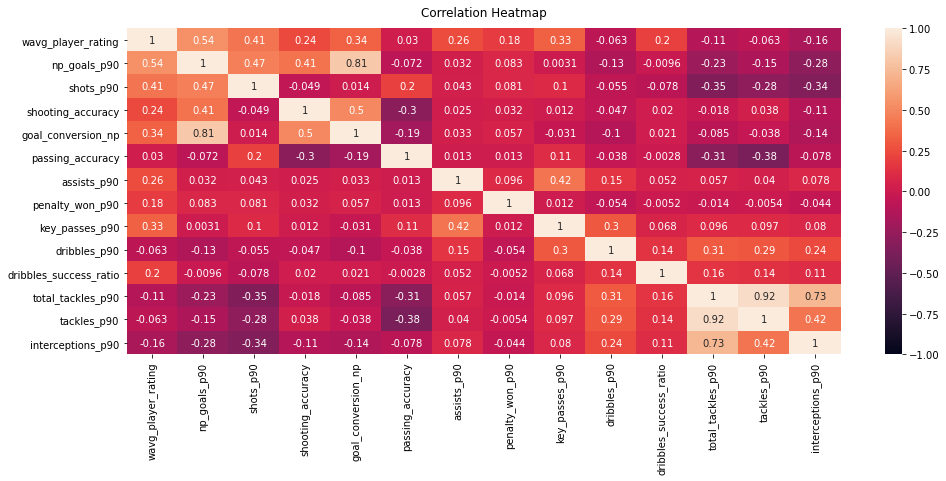

In [23]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_fw[fw_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [24]:
pca_object = decomposition.PCA().fit(df_fw[fw_cols])

In [25]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
variance,3.06,2.18,1.65,1.41,0.91,0.67,0.57,0.46,0.39,0.27,0.24,0.12,0.06,0.00
proportion of variance explained,0.26,0.18,0.14,0.12,0.08,0.06,0.05,0.04,0.03,0.02,0.02,0.01,0.01,0.00
cumulative proportion,0.26,0.44,0.57,0.69,0.77,0.82,0.87,0.91,0.94,0.96,0.98,0.99,1.00,1.00


Text(0, 0.5, 'Variance')

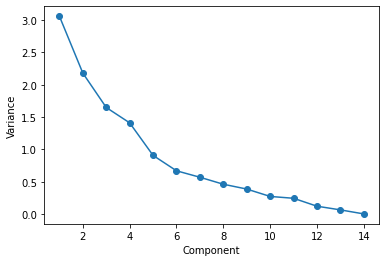

In [26]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [80]:
my_pca_components = pca_components(pca_object, df_fw[fw_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
wavg_player_rating,0.417,-0.046,0.219,-0.168,-0.085,-0.609,-0.110,-0.217,0.230,-0.179,-0.470,-0.009,0.064,-0.001
np_goals_p90,0.649,-0.340,-0.034,0.111,-0.131,0.189,0.020,0.246,-0.138,-0.065,0.096,0.016,-0.550,-0.003
shots_p90,0.232,-0.070,-0.051,-0.321,-0.270,-0.178,0.571,0.183,-0.199,0.340,0.192,0.111,0.409,0.001
shooting_accuracy,0.166,-0.100,0.041,0.233,0.116,0.096,-0.097,-0.352,0.314,0.805,-0.027,0.054,-0.030,-0.001
goal_conversion_np,0.347,-0.206,0.009,0.263,0.071,0.312,-0.304,0.050,0.020,-0.214,0.059,-0.010,0.722,0.004
passing_accuracy,-0.018,0.048,-0.129,-0.604,-0.268,0.183,-0.565,0.321,0.113,0.239,-0.104,-0.088,0.006,-0.005
assists_p90,0.129,0.151,0.660,-0.303,0.545,0.234,0.071,0.107,-0.222,0.080,-0.091,-0.028,-0.011,0.001
penalty_won_p90,0.388,0.886,-0.188,0.134,-0.059,0.072,-0.002,-0.011,-0.006,-0.001,0.041,0.007,-0.009,-0.002
key_passes_p90,0.047,0.041,0.321,-0.159,-0.080,-0.089,-0.046,-0.078,0.520,-0.175,0.735,0.028,-0.051,0.006
dribbles_p90,-0.110,0.063,0.477,0.105,-0.690,0.387,0.121,-0.235,-0.036,-0.051,-0.214,-0.021,-0.003,0.004


In [81]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_fw[fw_cols])
pca_embedding.shape

(948, 10)

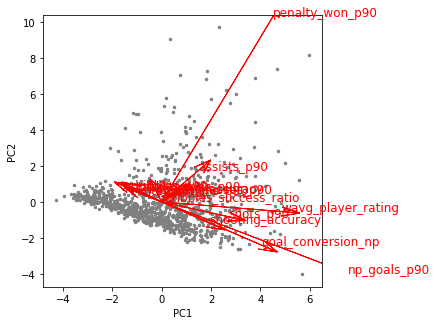

In [82]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

**Princeton - Factor Analysis**

Uniqueness is the variance that is ‘unique’ to the variable and not shared with other variables. It is equal to 1 – communality
(variance that is shared with other variables). For example, 61.57% of the variance in ‘ideol’ is not share with other
variables in the overall factor model. On the contrary ‘owner’ has low variance not accounted by other variables (28.61%).
Notice that the greater ‘uniqueness’ the lower the relevance of the variable in the factor model.

The higher the communalities, the better for aggregating in a factor with other variables.

By default the rotation is varimax which produces orthogonal factors. This means that factors are not correlated to each other.
**This setting is recommended when you want to identify variables to create indexes or new variables without inter-correlated components**

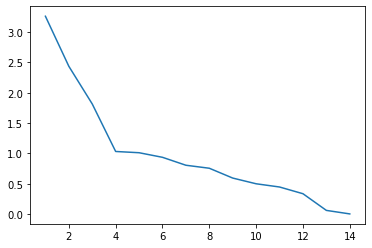

In [32]:
# Subset of the data, the 14 columns containing the survey answers
x = df_fw[fw_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [36]:
factors=4
method='principal'
rotation='varimax'
fa = FactorAnalyzer(factors, method=method, rotation=rotation)
fa.fit(x)
loads = fa.loadings_

In [48]:
variances = fa.get_factor_variance()[0]
variances_pct = [variances[i]/sum(variances) for i in range(len(variances))]

In [65]:
variances

array([2.94136   , 2.48625634, 1.87196653, 1.23823017])

In [64]:
(0.86882956**2)*0.34450977

0.2600583001207522

In [66]:
(loads**2)/variances

array([[1.44318899e-02, 8.59068095e-02, 1.32291197e-01, 1.63039042e-01],
       [2.77951552e-02, 2.72063013e-01, 5.97731596e-03, 4.99208785e-02],
       [9.55174763e-02, 5.50519186e-03, 3.40087328e-02, 1.13329264e-01],
       [1.74310133e-03, 2.26067709e-01, 2.78781869e-04, 1.11333742e-02],
       [7.02935457e-04, 3.07573533e-01, 6.78571204e-05, 2.05742640e-03],
       [8.00060687e-02, 7.58895780e-02, 2.11647504e-02, 1.08813013e-02],
       [2.13435303e-05, 1.48158388e-04, 2.33862223e-01, 3.38435379e-03],
       [1.59457223e-03, 3.16014869e-04, 1.65536415e-03, 5.78574206e-01],
       [2.83990895e-05, 3.51353483e-04, 3.59945998e-01, 1.45509478e-03],
       [3.27122947e-02, 5.32935687e-03, 1.43775146e-01, 5.44837521e-02],
       [1.42853153e-02, 7.22334926e-04, 3.61600798e-02, 8.61177790e-03],
       [3.04055494e-01, 1.03419846e-03, 1.14012181e-02, 1.25487857e-03],
       [2.56638019e-01, 1.11901558e-03, 8.43354418e-03, 1.62442132e-03],
       [1.70467934e-01, 1.79737324e-02, 1.09777920e

In [67]:
prueba =pd.DataFrame((loads**2)/variances, index=df_fw[fw_cols].columns, columns=['Factor {}'.format(fact+1) for fact in range(factors)])

In [69]:
prueba

,Factor 1,Factor 2,Factor 3,Factor 4
wavg_player_rating,0.01,0.09,0.13,0.16
np_goals_p90,0.03,0.27,0.01,0.05
shots_p90,0.10,0.01,0.03,0.11
shooting_accuracy,0.00,0.23,0.00,0.01
goal_conversion_np,0.00,0.31,0.00,0.00
passing_accuracy,0.08,0.08,0.02,0.01
assists_p90,0.00,0.00,0.23,0.00
penalty_won_p90,0.00,0.00,0.00,0.58
key_passes_p90,0.00,0.00,0.36,0.00
dribbles_p90,0.03,0.01,0.14,0.05


In [62]:
loads

array([[-0.20603248,  0.46215403,  0.49763912,  0.44931043],
       [-0.28592929,  0.82244659,  0.10577966,  0.24862328],
       [-0.53004838,  0.11699281,  0.25231569,  0.37460341],
       [ 0.07160369,  0.74970813, -0.02284448, -0.11741243],
       [-0.04547072,  0.87447507, -0.01127059,  0.05047343],
       [-0.48510478, -0.4343742 ,  0.19904699,  0.11607565],
       [ 0.00792332,  0.0191927 ,  0.66165116,  0.06473491],
       [ 0.06848511, -0.02803023, -0.05566674,  0.84640891],
       [-0.00913958, -0.02955596,  0.82085739, -0.04244693],
       [ 0.31019129, -0.11510928,  0.51878923, -0.25973722],
       [ 0.20498355,  0.04237818,  0.2601739 ,  0.10326356],
       [ 0.94569375, -0.05070781,  0.14609141,  0.03941863],
       [ 0.86882956,  0.05274618,  0.12564757,  0.04484872],
       [ 0.70810138, -0.21139372,  0.14335292, -0.01760233]])

In [78]:
def get_factors(x, factors, method='principal', rotation='varimax', thresh_c_alpha=0.5):
    fa = FactorAnalyzer(factors, method=method, rotation=rotation)
    fa.fit(x)
    # Get loadings
    loads = fa.loadings_
    # Get Variance
    var = pd.DataFrame(fa.get_factor_variance(), index=['Variance', 'Proportional Variance (%)', 'Cummulative (%)'], 
                 columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    # Get Communalities
    communalities = pd.DataFrame(fa.get_communalities(), columns=['Communalities'], index=x.columns)
    # Calculate Normalized Squared Factor Loadings
    variances = fa.get_factor_variance()[0]
    sq_norm_variances = (loads**2)/variances
    # Consolidate
    df_sq_factors = pd.DataFrame(sq_norm_variances, index=df_fw[fw_cols].columns, columns=['Sq Norm Factor {}'.format(fact+1) for fact in range(factors)])
    df_factors = pd.DataFrame(loads, index=x.columns, columns=['Factor {}'.format(fact+1) for fact in range(factors)])
    df_factors_var = pd.concat([pd.concat([df_factors, var]), communalities, df_sq_factors], axis=1)
    
    # Calculate Cronbach's coefficient alpha
    df_c_alpha = get_cronbach_alpha(x, df_factors_var, factors, threshold=thresh_c_alpha)
    
    return df_factors_var, df_c_alpha

In [76]:
def get_cronbach_alpha(df, df_factors, factors, threshold=0.5):
    list_c_alpha = []
    for factor in range(factors):
        cols_factor = df_factors[(~df_factors.index.isin(['Variance', 'Proportional Variance (%)', 'Cummulative (%)'])) & 
                   (df_factors[f'Factor {factor+1}']>=threshold)].index
        try:
            list_c_alpha.append([f'Factor {factor+1}', 
                                 pg.cronbach_alpha(df[cols_factor])[0], # C-Alpha
                                 pg.cronbach_alpha(df[cols_factor])[1]]) # Confidence Interval
        except:
            pass

    return pd.DataFrame(list_c_alpha, columns=['Factor', 'C-Alpha', 'Conf. Interval'])

In [77]:
display(get_factors(x, factors=4, method='principal', rotation='varimax')[0])
display(get_factors(x, factors=4, method='principal', rotation='varimax')[1])

,Factor 1,Factor 2,Factor 3,Factor 4,Communalities,Sq Norm Factor 1,Sq Norm Factor 2,Sq Norm Factor 3,Sq Norm Factor 4
wavg_player_rating,-0.21,0.46,0.50,0.45,0.71,0.01,0.09,0.13,0.16
np_goals_p90,-0.29,0.82,0.11,0.25,0.83,0.03,0.27,0.01,0.05
shots_p90,-0.53,0.12,0.25,0.37,0.50,0.10,0.01,0.03,0.11
shooting_accuracy,0.07,0.75,-0.02,-0.12,0.58,0.00,0.23,0.00,0.01
goal_conversion_np,-0.05,0.87,-0.01,0.05,0.77,0.00,0.31,0.00,0.00
passing_accuracy,-0.49,-0.43,0.20,0.12,0.48,0.08,0.08,0.02,0.01
assists_p90,0.01,0.02,0.66,0.06,0.44,0.00,0.00,0.23,0.00
penalty_won_p90,0.07,-0.03,-0.06,0.85,0.72,0.00,0.00,0.00,0.58
key_passes_p90,-0.01,-0.03,0.82,-0.04,0.68,0.00,0.00,0.36,0.00
dribbles_p90,0.31,-0.12,0.52,-0.26,0.45,0.03,0.01,0.14,0.05


,Factor,C-Alpha,Conf. Interval
0,Factor 1,0.85,"[0.835, 0.868]"
1,Factor 2,0.78,"[0.755, 0.804]"
2,Factor 3,0.51,"[0.448, 0.557]"


### Midfielders

In [114]:
df_mf = df_scaled[df_scaled['player_preferred_position'] == 'M'][player_cols+mf_cols].copy()

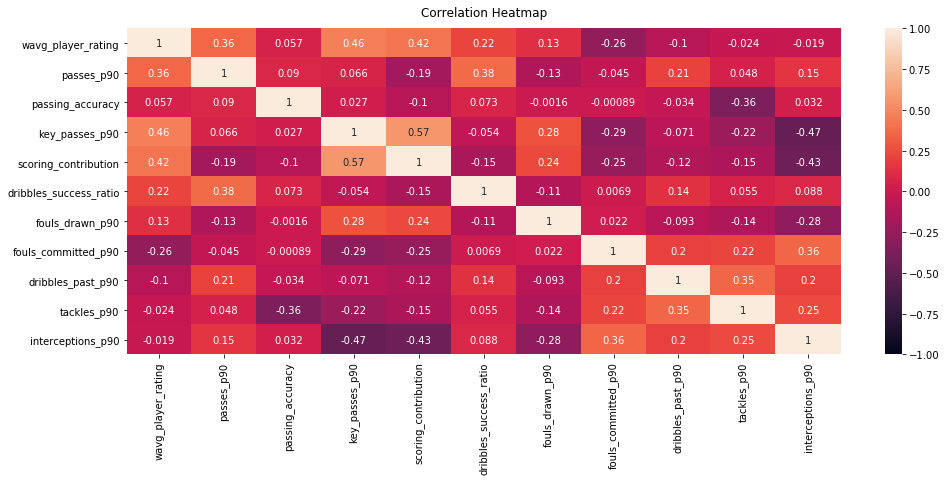

In [115]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_mf[mf_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [123]:
pca_object = decomposition.PCA().fit(df_mf[mf_cols])

In [124]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
variance,2.55,1.64,1.41,0.97,0.78,0.69,0.54,0.43,0.40,0.33,0.20
proportion of variance explained,0.26,0.17,0.14,0.10,0.08,0.07,0.05,0.04,0.04,0.03,0.02
cumulative proportion,0.26,0.42,0.56,0.66,0.74,0.81,0.86,0.91,0.95,0.98,1.00


Text(0, 0.5, 'Variance')

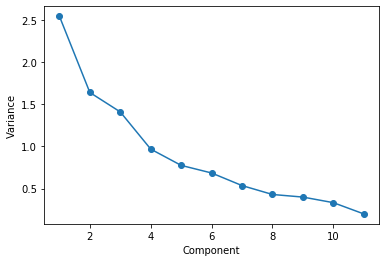

In [125]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [126]:
my_pca_components = pca_components(pca_object, df_mf[mf_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11
wavg_player_rating,0.40,0.50,0.02,-0.07,-0.33,0.38,-0.14,-0.22,0.05,-0.13,-0.50
passes_p90,-0.01,0.65,-0.23,-0.01,-0.12,-0.41,0.23,0.16,0.19,0.44,0.17
passing_accuracy,0.07,0.01,-0.68,0.36,0.23,0.36,-0.37,0.24,-0.04,0.14,0.07
key_passes_p90,0.53,0.12,0.13,0.14,0.27,-0.02,0.26,0.44,0.18,-0.51,0.22
scoring_contribution,0.45,-0.04,0.28,0.00,0.19,0.34,0.14,-0.26,-0.20,0.55,0.37
dribbles_success_ratio,-0.03,0.28,-0.11,-0.01,-0.09,-0.12,-0.00,-0.07,-0.86,-0.30,0.24
fouls_drawn_p90,0.26,-0.17,0.15,0.64,-0.46,-0.36,-0.31,-0.12,0.03,0.03,0.12
fouls_committed_p90,-0.29,-0.03,0.07,0.49,-0.24,0.34,0.62,0.20,-0.14,0.07,-0.20
dribbles_past_p90,-0.21,0.32,0.21,0.43,0.62,-0.13,-0.05,-0.41,0.04,-0.08,-0.18
tackles_p90,-0.29,0.26,0.55,0.01,-0.04,0.22,-0.46,0.50,-0.04,0.11,0.12


In [127]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_mf[mf_cols])
pca_embedding.shape

(2055, 10)

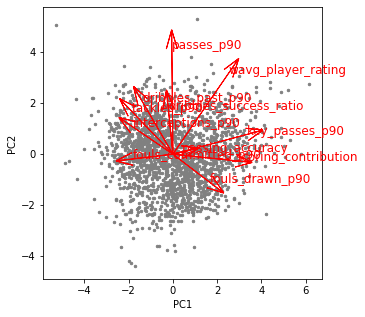

In [128]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

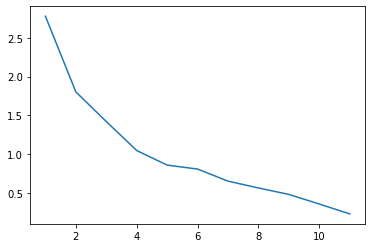

In [116]:
# Subset of the data, the 14 columns containing the survey answers
x = df_mf[mf_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [122]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(x)
loads = fa.loadings_
pd.DataFrame(loads, index=df_mf[mf_cols].columns, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'])

,Factor 1,Factor 2,Factor 3,Factor 4
wavg_player_rating,0.50,0.55,0.00,-0.13
passes_p90,-0.08,0.75,-0.04,-0.00
passing_accuracy,-0.05,0.13,-0.40,0.04
key_passes_p90,0.77,0.13,-0.08,-0.15
scoring_contribution,0.76,-0.10,0.05,-0.14
dribbles_success_ratio,-0.11,0.48,-0.02,0.01
fouls_drawn_p90,0.39,-0.14,-0.07,0.07
fouls_committed_p90,-0.17,-0.08,0.07,0.98
dribbles_past_p90,-0.15,0.21,0.27,0.18
tackles_p90,-0.19,0.11,0.97,0.14


In [131]:
#Create the factors
factor1 = df_mf[['wavg_player_rating', 'key_passes_p90', 'scoring_contribution']]
factor2 = df_mf[['wavg_player_rating', 'passes_p90', 'dribbles_success_ratio']]
factor3 = df_mf[['tackles_p90', 'dribbles_past_p90']]
factor4 = df_mf[['fouls_committed_p90', 'interceptions_p90']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
factor4_alpha = pg.cronbach_alpha(factor4)

print(factor1_alpha, factor2_alpha, factor3_alpha, factor4_alpha)

(0.7347214414529345, array([0.714, 0.754])) (0.5766880178222364, array([0.544, 0.607])) (0.5208155332441504, array([0.478, 0.561])) (0.5217791950466084, array([0.479, 0.561]))


### Defenders

In [133]:
df_df = df_scaled[df_scaled['player_preferred_position'] == 'D'][player_cols+df_cols].copy()

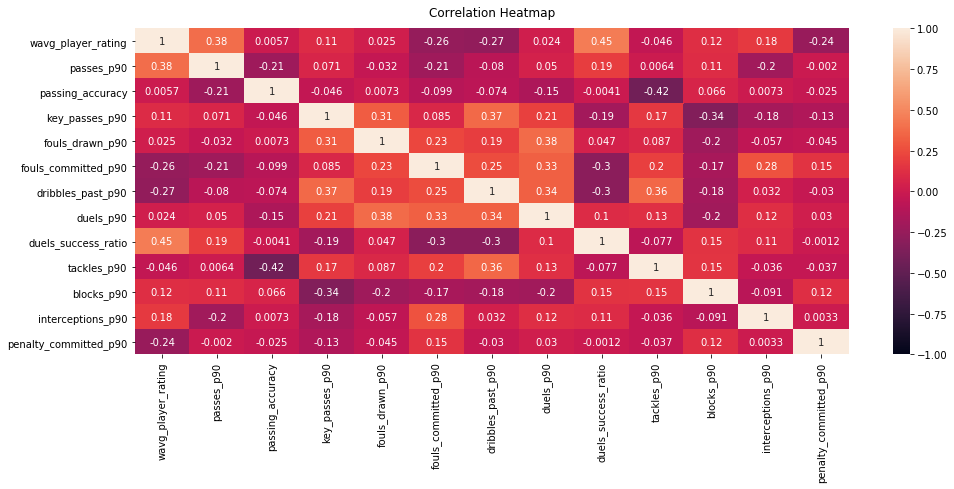

In [135]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_df[df_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [136]:
pca_object = decomposition.PCA().fit(df_df[df_cols])

In [137]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
variance,2.06,1.86,1.54,1.13,0.95,0.72,0.46,0.43,0.36,0.30,0.21,0.16,0.15
proportion of variance explained,0.20,0.18,0.15,0.11,0.09,0.07,0.04,0.04,0.03,0.03,0.02,0.02,0.01
cumulative proportion,0.20,0.38,0.53,0.64,0.73,0.80,0.84,0.89,0.92,0.95,0.97,0.98,1.00


Text(0, 0.5, 'Variance')

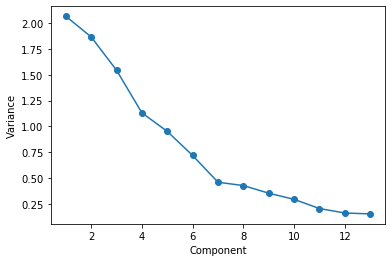

In [138]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [140]:
my_pca_components = pca_components(pca_object, df_df[df_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
wavg_player_rating,-0.15,-0.39,0.02,-0.52,0.20,-0.29,0.22,0.10,0.28,-0.30,-0.24,0.00,0.38
passes_p90,0.01,-0.19,0.14,-0.43,-0.31,-0.19,-0.48,0.35,0.02,0.46,0.21,0.01,-0.11
passing_accuracy,0.02,-0.14,-0.55,0.36,0.10,-0.58,0.18,0.17,0.07,0.36,-0.03,0.08,-0.05
key_passes_p90,-0.14,0.13,0.08,-0.06,-0.14,-0.34,0.08,0.10,0.18,-0.46,0.08,-0.13,-0.73
fouls_drawn_p90,-0.08,0.11,0.04,-0.05,0.01,-0.33,-0.03,-0.50,0.10,-0.07,0.73,0.10,0.25
fouls_committed_p90,0.02,0.27,0.10,0.08,0.29,-0.08,-0.35,-0.20,0.56,0.21,-0.23,-0.50,0.04
dribbles_past_p90,-0.09,0.27,0.23,0.18,0.04,-0.40,-0.19,0.33,-0.51,-0.23,-0.04,-0.32,0.34
duels_p90,-0.06,0.15,0.10,-0.13,0.13,-0.30,-0.29,-0.42,-0.25,0.05,-0.46,0.53,-0.15
duels_success_ratio,0.02,-0.20,-0.03,-0.30,0.11,-0.06,0.28,-0.38,-0.46,0.27,-0.02,-0.54,-0.23
tackles_p90,0.00,0.10,0.70,0.12,0.11,-0.13,0.51,0.13,0.12,0.37,0.01,0.16,-0.03


In [141]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_df[df_cols])
pca_embedding.shape

(1715, 10)

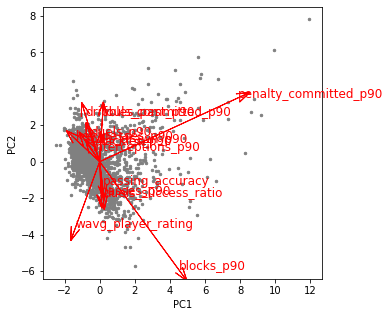

In [142]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

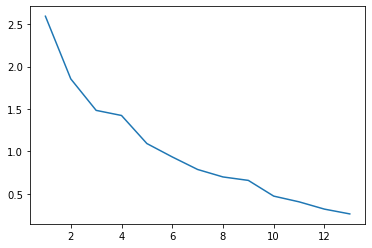

In [143]:
# Subset of the data, the 14 columns containing the survey answers
x = df_df[df_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [150]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(x)
loads = fa.loadings_
pd.DataFrame(loads, index=df_df[df_cols].columns, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'])

,Factor 1,Factor 2,Factor 3,Factor 4
wavg_player_rating,0.04,0.83,-0.02,0.03
passes_p90,-0.01,0.43,0.14,-0.20
passing_accuracy,-0.03,-0.06,-0.44,-0.02
key_passes_p90,0.72,0.03,0.12,-0.36
fouls_drawn_p90,0.49,0.04,0.06,0.12
fouls_committed_p90,0.31,-0.38,0.19,0.49
dribbles_past_p90,0.45,-0.31,0.32,-0.01
duels_p90,0.50,0.07,0.20,0.35
duels_success_ratio,-0.15,0.59,-0.05,0.18
tackles_p90,0.04,-0.07,0.91,-0.03


In [154]:
#Create the factors
factor1 = df_df[['key_passes_p90', 'fouls_drawn_p90', 'dribbles_past_p90', 'duels_p90']]
factor2 = df_df[['wavg_player_rating', 'duels_success_ratio']]
factor3 = df_df[['tackles_p90', 'dribbles_past_p90']]
factor4 = df_df[['interceptions_p90', 'fouls_committed_p90']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
factor4_alpha = pg.cronbach_alpha(factor4)

print(factor1_alpha, factor2_alpha, factor3_alpha, factor4_alpha)

(0.6257828480424394, array([0.596, 0.654])) (0.5981947351712738, array([0.558, 0.635])) (0.5187495078164253, array([0.471, 0.562])) (0.423279273127275, array([0.366, 0.475]))


### Goalkeepers

In [155]:
df_gk = df_scaled[df_scaled['player_preferred_position'] == 'G'][player_cols+gk_cols].copy()

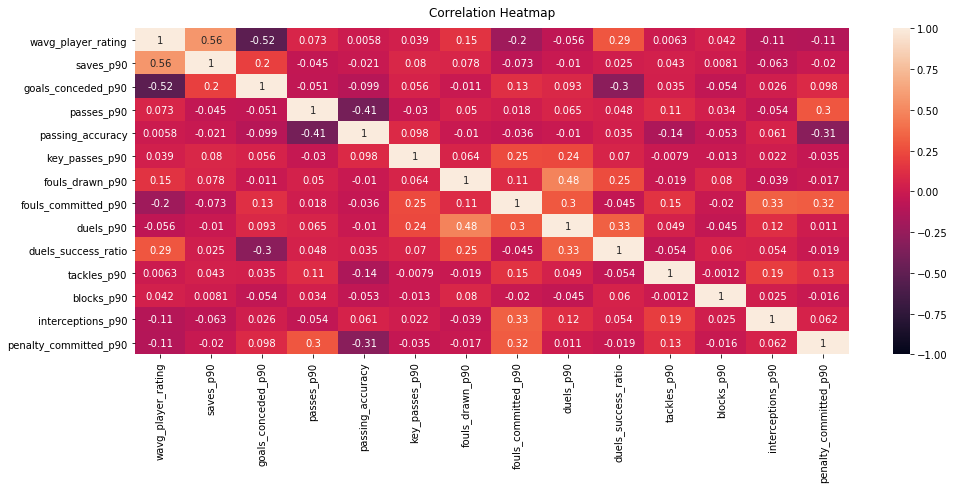

In [156]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_gk[gk_cols].corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### PCA

In [157]:
pca_object = decomposition.PCA().fit(df_gk[gk_cols])

In [158]:
pca_summary(pca_object)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
variance,3.33,1.45,1.04,0.79,0.18,0.12,0.09,0.02,0.01,0.01,0.00,0.00,0.00,0.00
proportion of variance explained,0.47,0.20,0.15,0.11,0.03,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
cumulative proportion,0.47,0.68,0.83,0.94,0.96,0.98,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Text(0, 0.5, 'Variance')

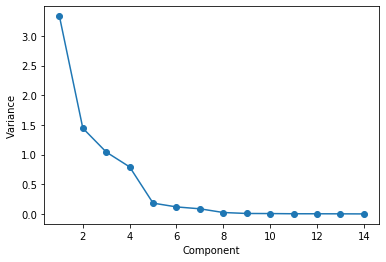

In [159]:
plt.plot(1+np.arange(len(pca_object.explained_variance_)), pca_object.explained_variance_, 'o-')
plt.xlabel('Component')
plt.ylabel('Variance')

In [161]:
my_pca_components = pca_components(pca_object, df_gk[gk_cols].columns)
my_pca_components.round(3)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14
wavg_player_rating,-0.32,0.69,0.29,-0.01,-0.08,-0.53,0.23,-0.04,0.01,0.01,-0.00,-0.01,0.00,0.00
saves_p90,-0.05,0.28,0.65,-0.18,0.08,0.63,-0.24,0.03,-0.01,-0.00,-0.00,0.00,-0.00,-0.00
goals_conceded_p90,0.33,-0.50,0.65,-0.17,-0.10,-0.40,0.13,-0.04,-0.01,0.01,-0.00,0.00,0.00,0.00
passes_p90,-0.02,0.01,0.04,0.29,-0.91,0.05,-0.29,-0.01,0.00,0.01,-0.01,0.00,0.01,-0.00
passing_accuracy,-0.03,0.04,-0.24,-0.91,-0.32,0.03,0.06,-0.00,-0.01,0.00,0.01,-0.00,0.00,0.00
key_passes_p90,-0.00,-0.00,0.01,-0.01,-0.01,-0.01,0.00,0.04,0.77,-0.54,-0.07,0.30,-0.12,-0.01
fouls_drawn_p90,-0.02,-0.01,0.02,-0.00,-0.02,-0.06,0.01,0.97,-0.12,0.02,-0.06,0.19,0.02,-0.02
fouls_committed_p90,0.00,-0.01,-0.00,0.00,-0.01,0.03,0.05,0.07,0.34,0.14,0.02,-0.27,0.88,-0.00
duels_p90,-0.01,-0.02,0.01,-0.00,-0.01,-0.01,-0.01,0.22,0.28,0.02,0.24,-0.82,-0.38,0.06
duels_success_ratio,-0.89,-0.45,0.11,-0.02,0.01,0.01,-0.01,-0.03,-0.01,-0.00,0.00,0.01,0.01,-0.00


In [164]:
pca_embedding = decomposition.PCA(n_components=10).fit_transform(df_gk[gk_cols])
pca_embedding.shape

(375, 10)

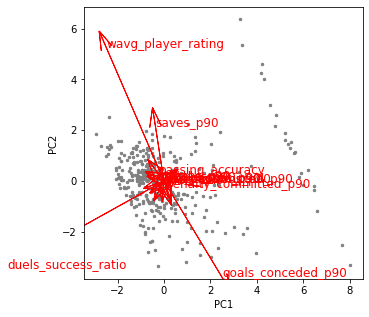

In [165]:
biplot(pca_embedding, my_pca_components)

#### Factor Analysis

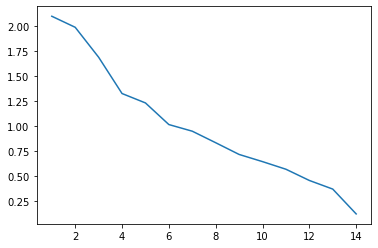

In [166]:
# Subset of the data, the 14 columns containing the survey answers
x = df_gk[gk_cols]
fa = FactorAnalyzer()
fa.fit(x, 10)
#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
ev
plt.plot(range(1,x.shape[1]+1),ev)

In [167]:
fa = FactorAnalyzer(4, rotation='varimax')
fa.fit(x)
loads = fa.loadings_
pd.DataFrame(loads, index=df_gk[gk_cols].columns, columns=['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'])

,Factor 1,Factor 2,Factor 3,Factor 4
wavg_player_rating,0.73,0.59,-0.06,-0.05
saves_p90,-0.05,1.00,0.04,0.02
goals_conceded_p90,-0.72,0.14,0.12,0.13
passes_p90,0.20,-0.04,-0.02,0.58
passing_accuracy,-0.04,-0.02,0.07,-0.62
key_passes_p90,-0.04,0.07,0.30,-0.06
fouls_drawn_p90,0.19,0.08,0.47,0.02
fouls_committed_p90,-0.21,-0.11,0.41,0.23
duels_p90,0.07,-0.04,0.87,0.05
duels_success_ratio,0.46,0.02,0.33,-0.05


In [170]:
#Create the factors
factor1 = df_gk[['wavg_player_rating', 'duels_success_ratio']]
factor2 = df_gk[['wavg_player_rating', 'saves_p90']]
factor3 = df_gk[['duels_p90', 'fouls_drawn_p90']]
factor4 = df_gk[['penalty_committed_p90', 'passing_accuracy', 'passes_p90']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)

factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
factor4_alpha = pg.cronbach_alpha(factor4)

print(factor1_alpha, factor2_alpha, factor3_alpha, factor4_alpha)

(0.419805645325394, array([0.289, 0.526])) (0.7000856406631855, array([0.633, 0.755])) (0.5246946534202754, array([0.418, 0.612])) (-0.9341650316857145, array([-1.3  , -0.618]))
